In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import cv2
import sys
import math
import pickle as pk
import random
from pathlib import Path
PIPELINE_ROOT = Path('./').resolve().parent.parent.parent
sys.path.append(PIPELINE_ROOT.as_posix())
print(PIPELINE_ROOT)

from src.library.utilities.utilities_process import read_image, write_image

/home/eddyod/programming/pipeline


In [2]:
def show_image(img, increaser=1, _title="", fsize=[15,15]):
    plt.figure(figsize=[15,15])
    plt.imshow(img * increaser, cmap="gray")
    plt.title(_title,fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.show()

def collect_positives(uimg, startr, startc, tile_width, tile_height):
    img=np.copy(uimg)
    positives=[]
    radius = 80
    a=int(radius/2)
    color = (65000)
    min_row, min_col = startr, startc
    for index,r in df.iterrows():
        col = int(round(r['x'])-min_col)
        row = int(round(r['y'])-min_row)
        if (col<0) or (col>tile_width) or (row<0) or (row>tile_height):
            continue
        img=cv2.circle(img, (int(col), int(row)), radius, color, 20)
        I=uimg[row-a:row+a,col-a:col+a]
        if I.shape==(radius,radius):
            positives.append((col,row,I))

    return img,positives

In [3]:
animal = 'DK184'
section = 204
channel = 3
prep_path = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'

In [4]:
tif = str(section).zfill(3) + ".tif"
filepath = os.path.join(prep_path, f'C{channel}/full_aligned', tif)
full_img = read_image(filepath)
full_img.shape

(19000, 30000)

In [ ]:
resize = True
if resize:
    filepath = os.path.join(prep_path, f'C{channel}/full_aligned', tif)
    startr = 6000
    endr = 25000
    startc = 35000
    endc = 65000
    img = full_img[startr:endr, startc:endc]
    print(img.shape)
    write_image(filepath, img)


In [15]:
dfpath = os.path.join(prep_path, 'cell_labels', 'all_predictions.csv')
df = pd.read_csv(dfpath)
df = df.sort_values(['section', 'x', 'y'])

In [16]:
df = df.loc[df['section'] == section]
print(df.head(3))
print(df.tail(3))

        x       y  section
0  5870.0  8518.0      204
1  5891.0  8104.0      204
2  5892.0  8301.0      204
          x        y  section
9   25018.0     73.0      204
10  27113.0  13467.0      204
11  29850.0  12039.0      204


In [17]:
count = len(df.index)
print(count)

12


In [18]:
startc = int(round(min(df['x']), -3))
startr = int(round(min(df['y']), -3))
endc = math.ceil(max(df['x']))
endr = math.ceil(max(df['y']))
# manually set to ROI
startr = 0
endr = full_img.shape[0]
startc = 0
endc = full_img.shape[1]

#startr = 0
#endr = 20000
#startc = 35000
#endc = full_img.shape[1]

print(startr, endr, startc, endc)

0 19000 0 30000


In [19]:
tile_width = endc - startc
tile_height = endr - startr
img = full_img[startr:endr, startc:endc]
print(f'{startr}:{endr}, {startc}:{endc}')
print(img.shape)
#img.shape # (6800, 30000)

0:19000, 0:30000
(19000, 30000)


In [20]:
annotated_img, positives = collect_positives(img, startr, startc, tile_width, tile_height)
print(len(positives))

12


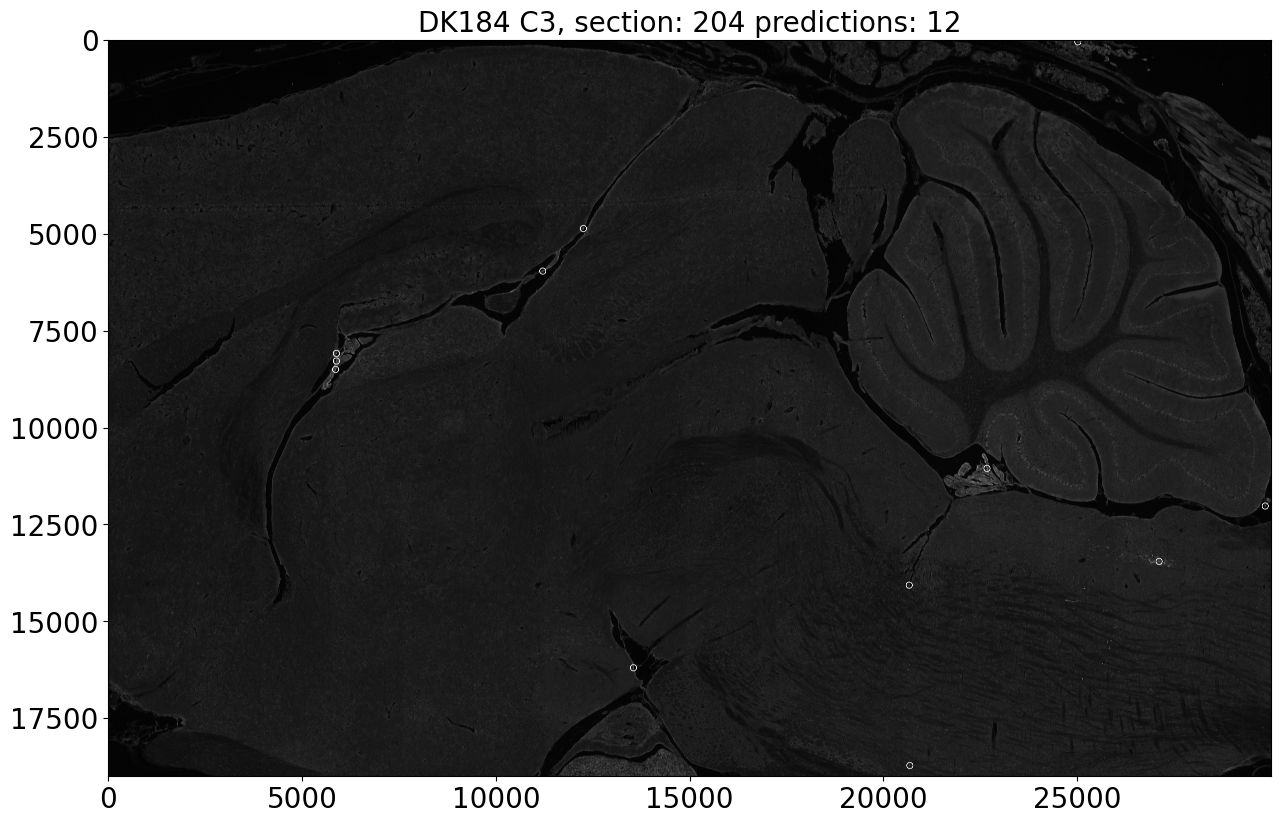

In [21]:
#vimg=annotated_img[in_row_min:in_row_max, in_col_min: in_col_max]
increaser = 5
show_image(annotated_img, increaser=increaser,_title=f'{animal} C{channel}, section: {section} predictions: {len(positives)}')

In [22]:
if len(positives) > 100:
    positives = b = random.sample(positives, 100)
print(len(positives))

12


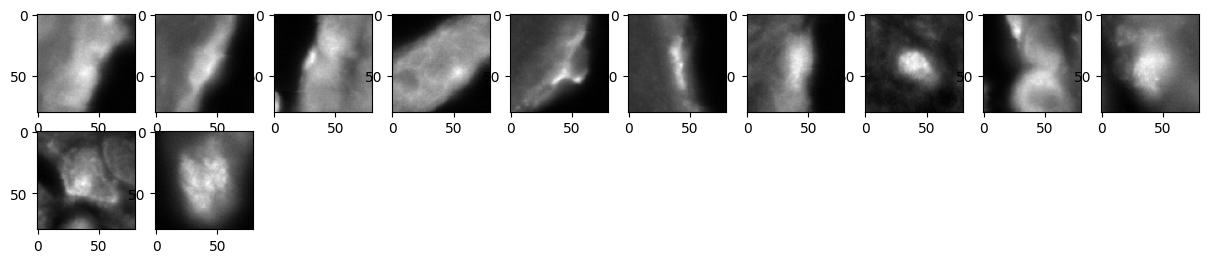

In [23]:
plt.figure(figsize=[15,15])
end = min(100, len(positives))
for i in range(len(positives[0:end])):
    plt.subplot(10,10,i+1)
    plt.imshow(positives[i][2], cmap="gray")
plt.show()

S.shape (12, 80, 80)
Mean.shape (80, 80)


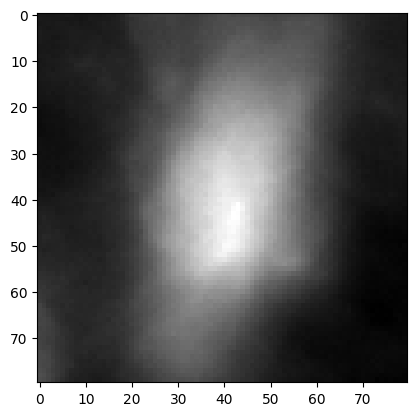

before: mean=2315.06 std=943.91
after: mean=-0.00 std= 1.00
-rw-r--r-- 1 eddyod eddyod 51362 Feb 21 08:14 mean.pkl


In [24]:
S=np.stack([I for (x,y,I)in positives])
print('S.shape', S.shape)

Mean=np.mean(S,axis=0)
print('Mean.shape', Mean.shape)

plt.imshow(Mean, cmap="gray")
plt.show()

_mean=np.mean(Mean.flatten())
_std=np.std(Mean.flatten())
print('before: mean=%5.2f std=%5.2f'%(_mean,_std))

Mean = (Mean-_mean)/_std

_mean=np.mean(Mean.flatten())
_std=np.std(Mean.flatten())
print('after: mean=%5.2f std=%5.2f'%(_mean,_std))

with open('mean.pkl','wb') as pkl_file:
    pk.dump({'Mean':Mean},pkl_file)

!ls -l *.pkl

In [25]:
S8 = (S/256).astype(np.uint8)
mid = S.shape[0] // 2
S80 = S8[mid, ...]
contours, _ = cv2.findContours(S80, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
ids, counts = np.unique(contours[0], return_counts=True)
ids,counts

(array([ 0,  6,  7,  8, 68, 69, 70, 78, 79], dtype=int32),
 array([4, 1, 1, 1, 1, 1, 1, 2, 8]))

In [26]:
cnt = contours[0]
M = cv2.moments(cnt)
Hm = cv2.HuMoments(M)
cv2.drawContours(S80, [cnt], -1, (0,255,255), 3)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

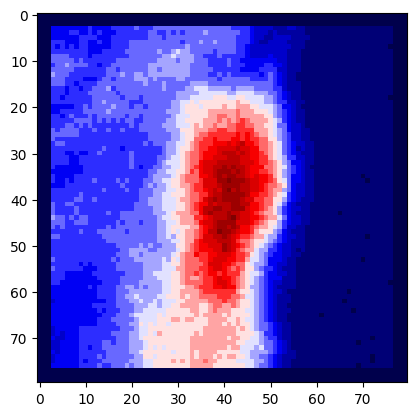

In [27]:
plt.imshow(S80, cmap="seismic")
plt.show()